In [3]:
import xarray as xray
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import hilbert
import matplotlib.dates as mdates

from iwaves.utils.minmax import get_peak_window
from soda.dataio.conversion.readotps import tide_pred

from mycurrents import oceanmooring as om
from netCDF4 import Dataset
import seaborn as sns
omega = 1.42e-4


In [4]:
%matplotlib notebook


In [5]:

# Rowley Shoals data
ncfile = '../processed_data/RowleyShoals_Fitted_Buoyancy_Tonly_csv.nc'
sitename = 'T330' # 150, 200
mode=1

In [6]:
#ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/browse-basin-kissme/Data/NetCDF/KISSME_Fitted_Buoyancy_wout_motion_unvenfilt.nc'
#ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/browse-basin-kissme/Data/NetCDF/KISSME_Fitted_Buoyancy_Tonly_csv.nc'
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/browse-basin-kissme/Data/NetCDF/KISSME_Fitted_Buoyancy_Combined.nc'

sitename = 'NP250' # 150, 200

In [7]:
ds = xray.open_dataset(ncfile, group=sitename)
raw = ds.A_n[:,mode]#.sel(time=slice('2019-4-1','2019-4-2'))

<IPython.core.display.Javascript object>


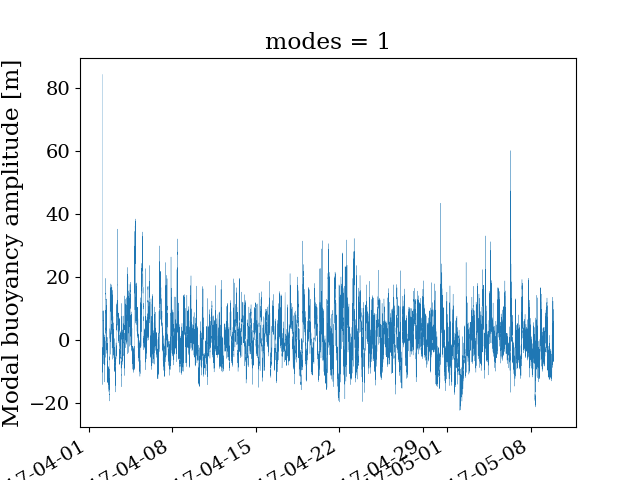

In [8]:
raw.plot(lw=0.2)

<IPython.core.display.Javascript object>


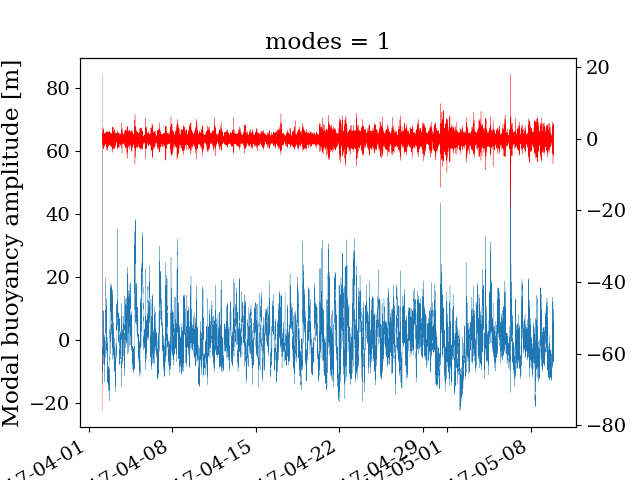

In [9]:
dAdt = np.diff(raw,1)
plt.figure()
raw.plot(lw=0.2)
plt.twinx()
plt.plot(raw.time[1:],dAdt,'r',lw=0.2)

In [12]:
from scipy.interpolate import splrep, splev

In [13]:
t = raw.time.values.astype(np.float)*1e-9
#f = splrep(t,raw.values,k=5,s=3600.)
f = splrep(t,raw.values,k=5,s=36000.)

In [14]:
raw_s = splev(t,f)
dAdt_s=splev(t,f,der=1)

<IPython.core.display.Javascript object>


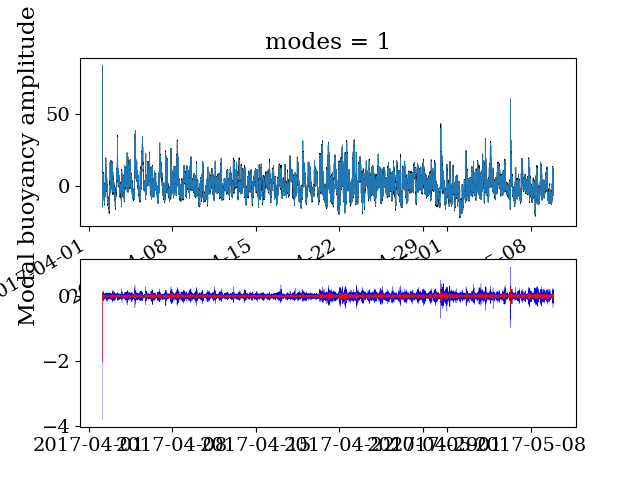

In [15]:
plt.figure()
ax1=plt.subplot(211)
raw.plot(c='k',lw=0.5)
plt.plot(raw.time, raw_s,lw=0.5)
plt.subplot(212,sharex=ax1)
plt.plot(raw.time[0:-1],dAdt/20.,'b',lw=0.2)
plt.plot(raw.time, dAdt_s,'r', lw=0.5)


<IPython.core.display.Javascript object>


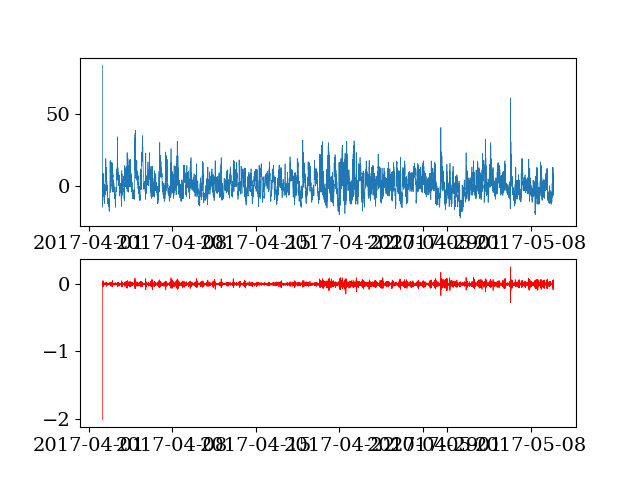

In [16]:
plt.figure()
ax1=plt.subplot(211)
plt.plot(raw.time, raw_s,lw=0.5)
plt.subplot(212,sharex=ax1)
plt.plot(raw.time, dAdt_s,'r', lw=0.5)

<IPython.core.display.Javascript object>


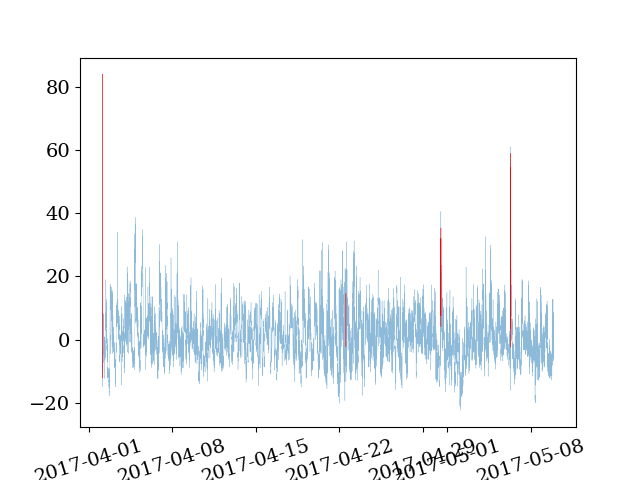

(array([736420., 736427., 736434., 736441., 736448., 736450., 736457.]),
 <a list of 7 Text xticklabel objects>)

In [18]:
# Just show where dAdt > threshold
idx = np.abs(dAdt_s)>0.10
dAdt_c = 0*dAdt_s
dAdt_c[~idx] = np.nan
A_c = 1*raw_s
A_c[~idx] = np.nan

plt.figure()
#plt.plot(raw.time, dAdt_s,lw=0.5)
#plt.plot(raw.time, dAdt_c,'r', lw=1.5)
plt.plot(raw.time, raw_s,lw=0.25,alpha=0.5)
plt.plot(raw.time, A_c,'r', lw=0.5)
plt.xticks(rotation=17)

<IPython.core.display.Javascript object>


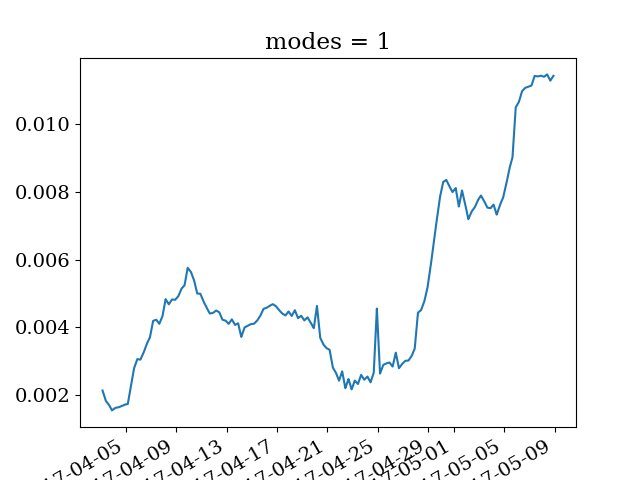

In [19]:
# Calculate Ls
a0 = ds['amp'][:,mode,0]
r10 = ds['r10'][:,mode]
c1 = ds['cn'][:,mode]
alpha = -2*r10*c1

omega = 2*np.pi/(12.42*3600)
tau_s = 1/(2*np.pi*omega*r10*a0)
L_s = c1*tau_s

L_s_all = np.abs(L_s.interp({'timeslow':ds.time}, method='linear'))
alpha_all = alpha.interp({'timeslow':ds.time}, method='linear')
a0_all = a0.interp({'timeslow':ds.time}, method='linear')

plt.figure()
alpha_all.plot()

In [20]:
# plot joint distribution
data = {'Ls':L_s_all/1000,'alpha':alpha_all, 'A':raw_s, 'dAdt':dAdt_s,'a0':a0_all}

<IPython.core.display.Javascript object>


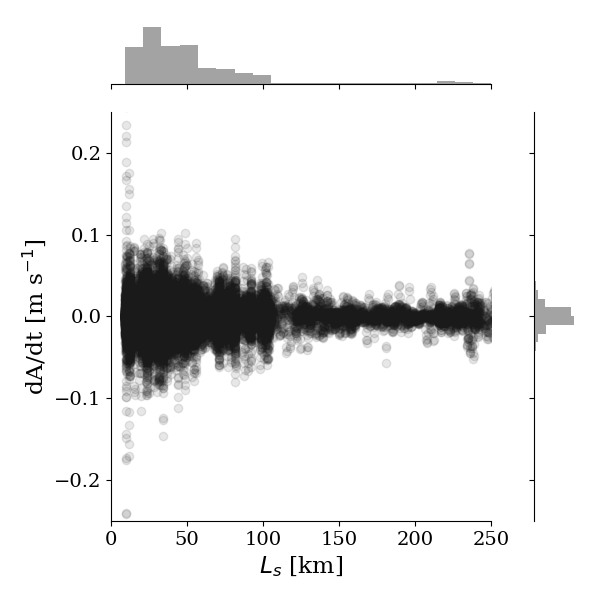

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


In [21]:
g = sns.jointplot("Ls",'dAdt', data=data, color='0.1',joint_kws={'alpha':0.1,},\
                  ylim=(-0.25,0.25), xlim=(0,250))
g.ax_joint.legend_.remove()
g.set_axis_labels('$L_s$ [km]','dA/dt [m s$^{-1}$]')
plt.tight_layout()

plt.savefig('../FIGURES/dAdt_vs_Ls_jointplot_{}_90dpi.png'.format(sitename),dpi=90)
plt.savefig('../FIGURES/dAdt_vs_Ls_jointplot_{}_300dpi.png'.format(sitename),dpi=300)

<IPython.core.display.Javascript object>


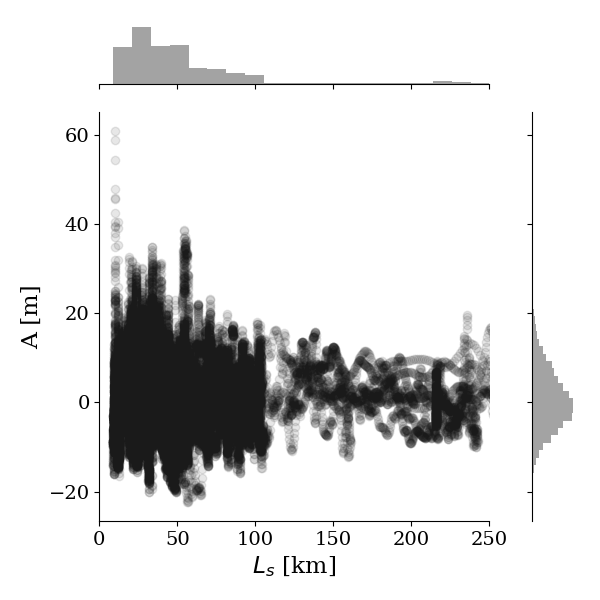

In [22]:
g = sns.jointplot("Ls",'A', data=data,color='0.1', joint_kws={'alpha':0.1,},xlim=(0,250))
g.ax_joint.legend_.remove()
g.set_axis_labels('$L_s$ [km]','A [m]')
plt.tight_layout()

plt.savefig('../FIGURES/A_vs_Ls_jointplot_{}_90dpi.png'.format(sitename),dpi=90)
plt.savefig('../FIGURES/A_vs_Ls_jointplot_{}_300dpi.png'.format(sitename),dpi=300)

<IPython.core.display.Javascript object>


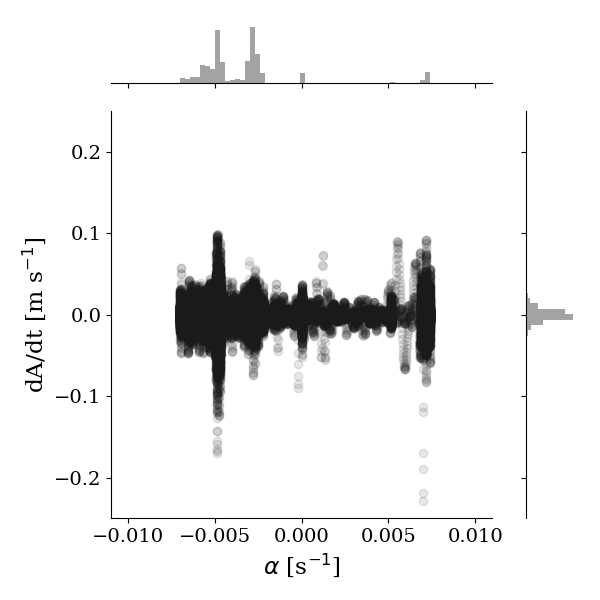

In [103]:
g = sns.jointplot("alpha",'dAdt', data=data, color='0.1',joint_kws={'alpha':0.1,},\
                  ylim=(-0.25,0.25), xlim=(-0.011,0.011))
g.ax_joint.legend_.remove()
g.set_axis_labels(r'$\alpha$ [s$^{-1}$]','dA/dt [m s$^{-1}$]')
plt.tight_layout()

plt.savefig('../FIGURES/dAdt_vs_alpha_jointplot_{}_90dpi.png'.format(sitename),dpi=90)
plt.savefig('../FIGURES/dAdt_vs_alpha_jointplot_{}_300dpi.png'.format(sitename),dpi=300)

<IPython.core.display.Javascript object>


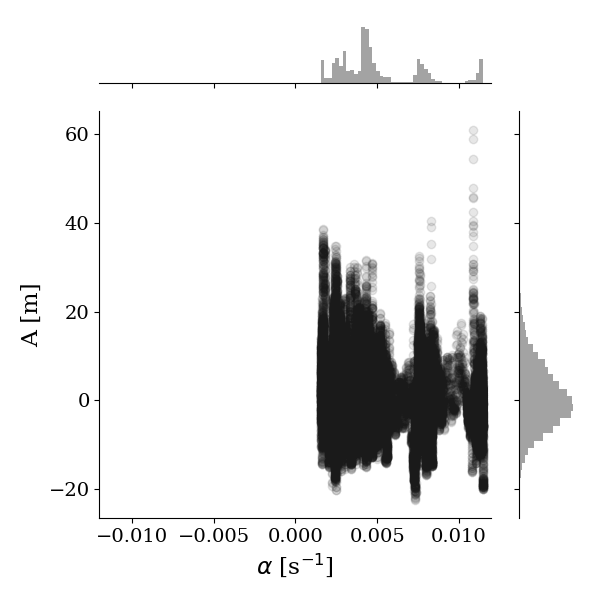

In [24]:
g = sns.jointplot("alpha",'A', data=data, color='0.1',joint_kws={'alpha':0.1,},\
                   xlim=(-0.012,0.012))
g.ax_joint.legend_.remove()
g.set_axis_labels(r'$\alpha$ [s$^{-1}$]','A [m]')
plt.tight_layout()

plt.savefig('../FIGURES/A_vs_alpha_jointplot_{}_90dpi.png'.format(sitename),dpi=90)
plt.savefig('../FIGURES/A_vs_alpha_jointplot_{}_300dpi.png'.format(sitename),dpi=300)

<IPython.core.display.Javascript object>


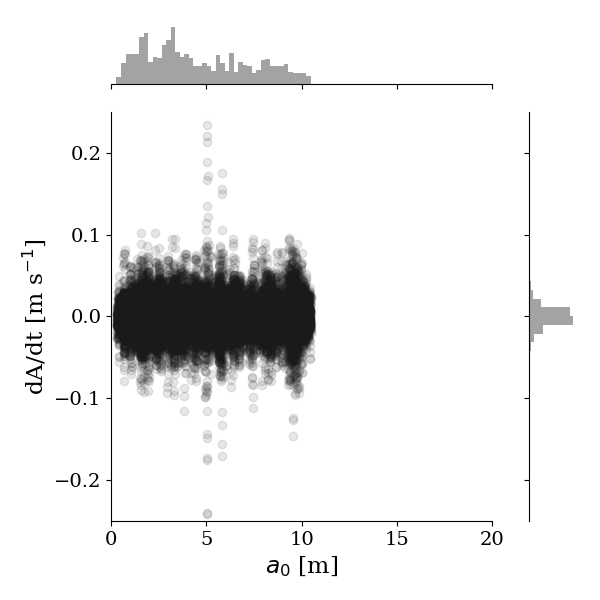

In [25]:
g = sns.jointplot("a0",'dAdt', data=data, color='0.1',joint_kws={'alpha':0.1,},\
                  ylim=(-0.25,0.25), xlim=(0,20))
g.ax_joint.legend_.remove()
g.set_axis_labels(r'$a_0$ [m]','dA/dt [m s$^{-1}$]')
plt.tight_layout()

plt.savefig('../FIGURES/dAdt_vs_a0_jointplot_{}_90dpi.png'.format(sitename),dpi=90)
plt.savefig('../FIGURES/dAdt_vs_a0_jointplot_{}_300dpi.png'.format(sitename),dpi=300)

<IPython.core.display.Javascript object>


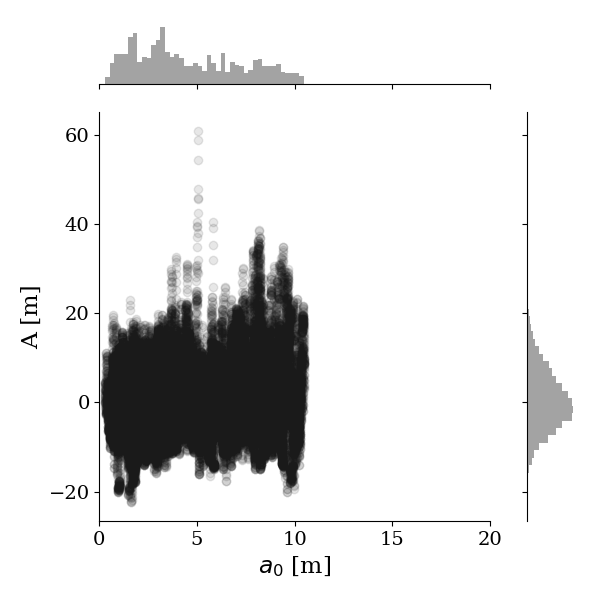

In [26]:
g = sns.jointplot("a0",'A', data=data, color='0.1',joint_kws={'alpha':0.1,},\
                   xlim=(0,20))
g.ax_joint.legend_.remove()
g.set_axis_labels(r'$a_0$ [m]','A [m]')
plt.tight_layout()

plt.savefig('../FIGURES/A_vs_a0_jointplot_{}_90dpi.png'.format(sitename),dpi=90)
plt.savefig('../FIGURES/A_vs_a0_jointplot_{}_300dpi.png'.format(sitename),dpi=300)